In [1]:
import numpy as np
import pandas as pd
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
import matplotlib.pyplot as plt
import math
import sys
import os

sys.path.append('../..')
from fastmbartools import FastMBARSolver

Follow FastMBAR tutorial, run umbrella simulation for butane and compute PMF with fastmbartools.

First run simulation with OpenMM. The data is produced by running script "run_umbrella.py", which follow the steps shown in FastMBAR tutorial. The samples are collected in "output/dihedral.csv". The first row is theta0 values, while following rows are the samples for each corresponding theta0 value. 

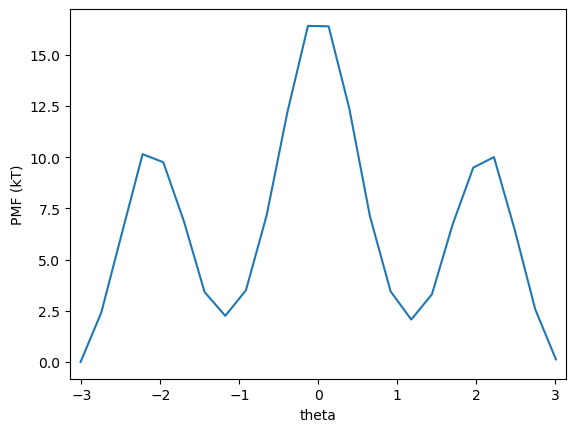

In [2]:
M = 20
k = 100 # umbrella force constants
df = pd.read_csv('output/dihedral.csv')
cv = []
parameters = []
for theta0 in df.columns:
    parameters.append(np.array([k, float(theta0)]))
    cv.append(df[theta0].to_numpy())
T = 298.15

# we cannot use default harmonic potential for this system, as dihedral is periodic, and during simulation 
# we need to define the new bias potential
def dihedral_harmonic_potential(theta, p):
    # assume theta is 2d array like, and p is 1d array like
    p = np.reshape(p, (-1, 2))
    k = p[:, 0]
    theta0 = p[:, 1]
    delta_theta = theta - theta0
    delta_theta = np.minimum(delta_theta, 2*np.pi - delta_theta)
    energy = np.sum(k*(delta_theta**2), axis=1)
    return energy

kB = 0.008314 # energy unit is kJ/mol, and temperature unit is K
solver = FastMBARSolver(T, cv, parameters, dihedral_harmonic_potential, kB)
solver.solve()
bins = [np.linspace(-np.pi, np.pi, 25)]
result = solver.compute_pmf(T, cv, bins)
theta = result['x']
PMF = result['PMF (kT)']
plt.plot(theta, PMF)
plt.xlabel('theta')
plt.ylabel('PMF (kT)')
plt.xlim((-np.pi, np.pi))
plt.show()